In [9]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
with open("../data/ltr/ltr-training-data.json") as file:
    raw_data = json.load(file)
    for idx, query in enumerate(raw_data):
        features = {item['name']: item['value'] for item in query['features']}
        raw_data[idx] = {**query, **features}
    df = pd.DataFrame(raw_data)

In [11]:
df['queryId'] = pd.factorize(df['searchTerm'])[0]

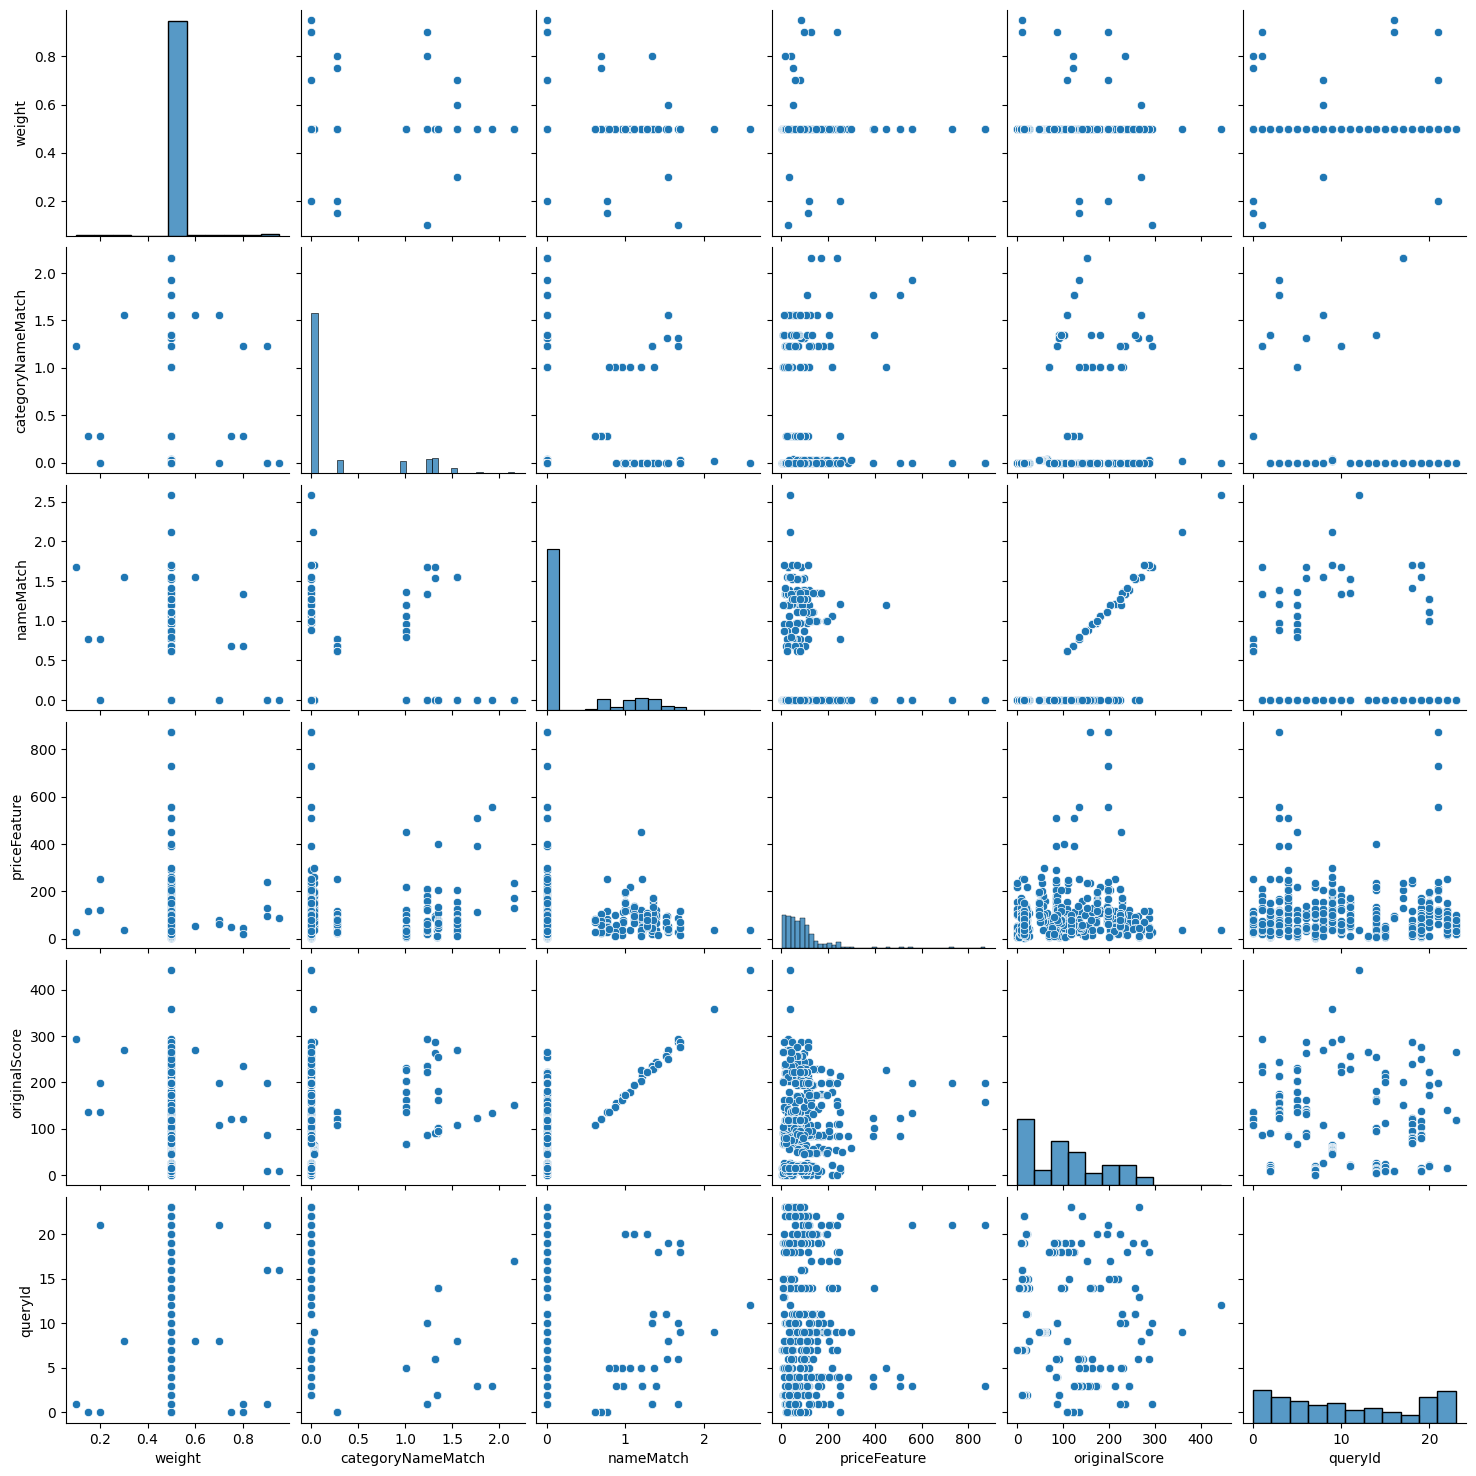

In [10]:
sns.pairplot(df)

In [7]:
display(df)

,searchTerm,productCode,weight,features,categoryNameMatch,nameMatch,priceFeature,originalScore,queryId
0,drill,3887529,0.50,"[{'name': 'categoryNameMatch', 'value': 0.2764...",0.276477,0.773474,81.0,135.358020,0
1,drill,3887483,0.15,"[{'name': 'categoryNameMatch', 'value': 0.2764...",0.276477,0.773474,116.0,135.358020,0
2,drill,3887477,0.20,"[{'name': 'categoryNameMatch', 'value': 0.2764...",0.276477,0.773474,254.0,135.358020,0
3,drill,3887475,0.50,"[{'name': 'categoryNameMatch', 'value': 0.2764...",0.276477,0.773474,32.0,135.358020,0
4,drill,3884646,0.50,"[{'name': 'categoryNameMatch', 'value': 0.2764...",0.276477,0.773474,70.0,135.358020,0
...,...,...,...,...,...,...,...,...,...
520,einhell,3880517,0.50,"[{'name': 'categoryNameMatch', 'value': 0.0}, ...",0.000000,0.000000,64.0,117.957535,23
521,einhell,3880504,0.50,"[{'name': 'categoryNameMatch', 'value': 0.0}, ...",0.000000,0.000000,42.0,117.957535,23
522,einhell,3879445,0.50,"[{'name': 'categoryNameMatch', 'value': 0.0}, ...",0.000000,0.000000,59.0,117.957535,23
523,einhell,3879444,0.50,"[{'name': 'categoryNameMatch', 'value': 0.0}, ...",0.000000,0.000000,79.0,117.957535,23


array([[<Axes: title={'center': 'weight'}>]], dtype=object)

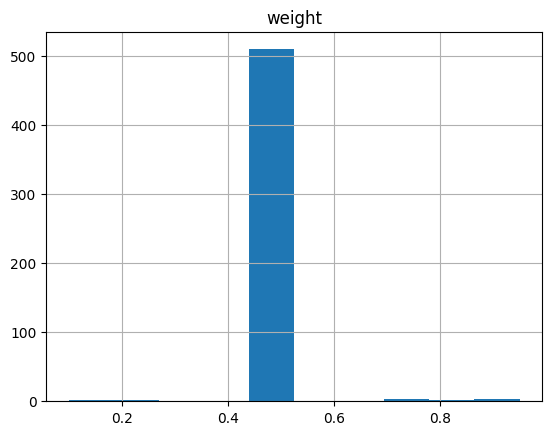

In [32]:
df.hist(column='weight')

In [30]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop(columns=['searchTerm', 'productCode', 'weight', 'features', 'queryId'])
y = df['weight']
group = df.groupby('queryId').size().to_list()

# Optional: split into train/test (use same query groups!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=df['queryId'])

# Align group sizes after split
train_queries = df.loc[X_train.index, 'queryId']
group_train = train_queries.value_counts().sort_index().tolist()

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [28]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train, group=group_train)

params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [1, 3],
    'learning_rate': 0.1,
    'num_leaves': 5,
    'min_data_in_leaf': 1,
}

model = lgb.train(params, train_data, num_boost_round=100)

[LightGBM] [Fatal] label should be int type (met 0.500000) for ranking task,
for the gain of label, please set the label_gain parameter


LightGBMError: label should be int type (met 0.500000) for ranking task,
for the gain of label, please set the label_gain parameter

In [27]:
y_pred = model.predict(X_test)

# Combine for easy inspection
results = X_test.copy()
results['true_relevance'] = y_test
results['predicted_score'] = y_pred

# Sort by predicted score per query
results['query_id'] = data.loc[X_test.index, 'query_id']
results_sorted = results.sort_values(by=['query_id', 'predicted_score'], ascending=[True, False])
print(results_sorted)


    feature_1  feature_2  true_relevance  predicted_score  query_id
2    0.347795   0.819553               1        -7.660738         1
6    0.685959   0.888612               2        -5.686095         2
10   0.638864   0.605967               2        -2.998834         3
14   0.536025   0.378653               2        -6.631581         4
19   0.828267   0.816282               1         7.453504         5
23   0.849486   0.026150               1         4.967187         6


In [28]:
model.dump_model()

{'name': 'tree',
 'version': 'v4',
 'num_class': 1,
 'num_tree_per_iteration': 1,
 'label_index': 0,
 'max_feature_idx': 1,
 'objective': 'lambdarank',
 'average_output': False,
 'feature_names': ['feature_1', 'feature_2'],
 'monotone_constraints': [],
 'feature_infos': {'feature_1': {'min_value': 0.025648999053874744,
   'max_value': 0.9736036956852333,
   'values': []},
  'feature_2': {'min_value': 0.0013848680488872669,
   'max_value': 0.9978752362740725,
   'values': []}},
 'tree_info': [{'tree_index': 0,
   'num_leaves': 5,
   'num_cat': 0,
   'shrinkage': 0.1,
   'tree_structure': {'split_index': 0,
    'split_feature': 1,
    'split_gain': 0.6494330167770386,
    'threshold': 0.19469511690471816,
    'decision_type': '<=',
    'default_left': True,
    'missing_type': 'None',
    'internal_value': 1.5173000000000001e-09,
    'internal_weight': 1.47312,
    'internal_count': 18,
    'left_child': {'leaf_index': 0,
     'leaf_value': 0.1999999999999985,
     'leaf_weight': 0.14624

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(random_state=42, n_estimators=100, min_samples_leaf=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
results = X_test.copy()
results['true_relevance'] = y_test
results['predicted_score'] = y_pred

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)

display(results)



MSE:  0.008167112961877514


,categoryNameMatch,nameMatch,priceFeature,originalScore,true_relevance,predicted_score
310,0.000000,0.000000,9.0,266.000400,0.5,0.502976
390,0.000000,1.700427,117.0,276.678380,0.5,0.480955
6,0.276477,0.773474,29.0,135.358020,0.5,0.489505
184,1.316941,0.000000,85.0,89.990944,0.5,0.500000
78,0.000000,1.389368,120.0,243.139340,0.5,0.469299
407,0.000000,0.000000,109.0,8.038113,0.5,0.500000
524,0.000000,0.000000,30.0,117.957535,0.5,0.500000
487,0.000000,0.000000,26.0,14.714725,0.5,0.500000
117,0.000000,0.000000,137.0,84.709000,0.5,0.500000
137,1.004762,1.364029,99.0,231.127200,0.5,0.498379
